# Access city database
This notebook shows how to access all data relative to cities that was harvested from the city subcubes. In the notebooks, data is loaded from the databased into (geo)pandas dataframes.

List of available data for cities (updated 20.06.23):
- Urban Atlas 2018: total area of UA classes within the city boundary (#pixels)
- Eurostat: annual socioeconomic and environmental variables from Eurostat, 1991-2021 (see Lookup tables)
- Environmental zones: environmental zone of the city (https://sdi.eea.europa.eu/catalogue/idp/api/records/6ef007ab-1fcd-4c4f-bc96-14e8afbcb688)
- Corine Land Cover (Water classes): total area of CLC Water classes within a buffer of the city boundary (#pixels)

Useful lookup tables:
- Urban Atlas: class codes and their description
- Environmental zones: class codes and their description
- Urban Audit: city/FUA codes, city names, center coordinates and bounding boxes (EPSG:3035 and WGS84)
- Corine Land Cover: class codes and their description

Note: Data is currently stored in sqlite databases on s3. In the future it will be stored in an external database (geodb)

- [ ] TODO adapt the notebook to work with geodb (start mid July '23)

## City cube tables (updated 06.07.23)
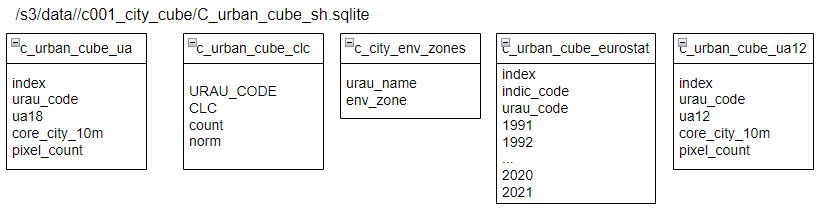

## Lookup tables (updated 06.07.23)
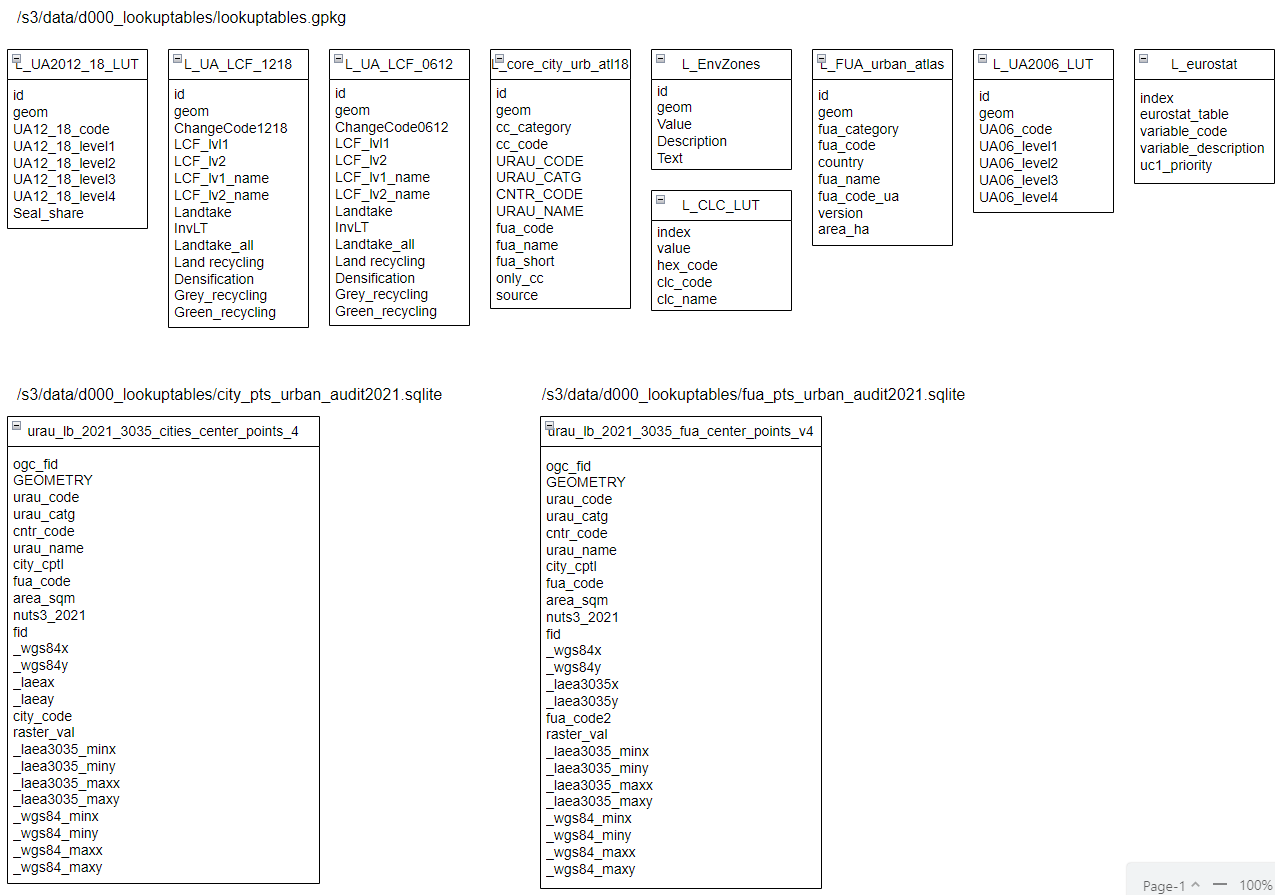

In [1]:
# loading in modules
import sqlite3
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt

# path to databases
data_folder = './../../../s3/data'
city_geom  = data_folder + '/d000_lookuptables/city_pts_urban_audit2021.sqlite'
fua_geom   = data_folder + '/d000_lookuptables/fua_pts_urban_audit2021.sqlite'
lookuptable= data_folder + '/d000_lookuptables/lookuptables.gpkg'
city_cube  = data_folder + '/c001_city_cube/C_urban_cube_sh.sqlite'

## List tables within a database, list columns of a table

In [3]:
# choose database
dbfile = lookuptable
# Create a SQL connection
con = sqlite3.connect(dbfile)
# create cursor
cur = con.cursor()
# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# print table list and for each table its columns
print("++++++++++++++")
for t in table_list:
    print("Table name: ", t[0])
    col_data = con.execute(f'PRAGMA table_info({t[0]});').fetchall()
    columns = [entry[1] for entry in col_data]
    print("-- Column names:")
    for col in columns:
        print(col)
    print("++++++++++++++")

# # Be sure to close the connection
con.close()

++++++++++++++
Table name:  gpkg_spatial_ref_sys
-- Column names:
srs_name
srs_id
organization
organization_coordsys_id
definition
description
++++++++++++++
Table name:  gpkg_contents
-- Column names:
table_name
data_type
identifier
description
last_change
min_x
min_y
max_x
max_y
srs_id
++++++++++++++
Table name:  gpkg_geometry_columns
-- Column names:
table_name
column_name
geometry_type_name
srs_id
z
m
++++++++++++++
Table name:  gpkg_tile_matrix_set
-- Column names:
table_name
srs_id
min_x
min_y
max_x
max_y
++++++++++++++
Table name:  gpkg_tile_matrix
-- Column names:
table_name
zoom_level
matrix_width
matrix_height
tile_width
tile_height
pixel_x_size
pixel_y_size
++++++++++++++
Table name:  L_UA2012_18_LUT
-- Column names:
id
geom
UA12_18_code
UA12_18_level1
UA12_18_level2
UA12_18_level3
UA12_18_level4
Seal_share
++++++++++++++
Table name:  sqlite_sequence
-- Column names:
name
seq
++++++++++++++
Table name:  L_UA_LCF_1218
-- Column names:
id
geom
ChangeCode1218
LCF_lvl1
LCF_lv2
L

## Urban atlas 2018

In [2]:
# get Urban Atlas data
con = sqlite3.connect(city_cube)
# read full table
ua18_all = pd.read_sql_query("SELECT * FROM c_urban_cube_ua", con)
# or get only some columns
ua18 = pd.read_sql_query("SELECT urau_code, ua18, pixel_count FROM c_urban_cube_ua", con)
con.close()
ua18
ua_18_sum = ua18.groupby(["urau_code", "ua18"]).sum().reset_index()
ua_18_sum

,urau_code,ua18,pixel_count
0,AT001C,11100,549560
1,AT001C,11210,743312
2,AT001C,11220,675268
3,AT001C,11230,199478
4,AT001C,11240,17678
...,...,...,...
15700,SK008C,21000,147220
15701,SK008C,23000,65839
15702,SK008C,31000,280810
15703,SK008C,32000,8386


In [4]:
ua18_all.to_csv("ua18.csv")

### Example: Add class description, make wide table, add environmental zones

In [29]:
# get class description
con_l = sqlite3.connect(lookuptable)
# read level-4 description
ua18_lookup = pd.read_sql_query("SELECT UA12_18_code, UA12_18_level4 FROM L_UA2012_18_LUT", con_l)
con_l.close()
# add description
ua_18_desc = pd.merge(ua_18_sum, ua18_lookup, how="inner", left_on="ua18", right_on="UA12_18_code")
ua_18_desc.drop("ua18", axis=1, inplace=True)
ua_18_desc

,urau_code,pixel_count,UA12_18_code,UA12_18_level4
0,AT001C,549560,11100,Continuous Urban Fabric (S.L. > 80%)
1,AT002C,26761,11100,Continuous Urban Fabric (S.L. > 80%)
2,AT003C,35295,11100,Continuous Urban Fabric (S.L. > 80%)
3,AT004C,12029,11100,Continuous Urban Fabric (S.L. > 80%)
4,AT005C,9836,11100,Continuous Urban Fabric (S.L. > 80%)
...,...,...,...,...
15419,SI001C,12483,24000,Complex and mixed cultivation
15420,SK001C,7494,24000,Complex and mixed cultivation
15421,CH003C,142,25000,Orchards
15422,FR076C,141,25000,Orchards


In [35]:
# make wide table
ua_18_wide = ua_18_desc.pivot(index="urau_code", columns=["UA12_18_level4"], values="pixel_count").reset_index()
ua_18_wide

UA12_18_level4,urau_code,Airports,Arable land (annual crops),Complex and mixed cultivation,Construction sites,Continuous Urban Fabric (S.L. > 80%),Discontinuous Dense Urban Fabric (S.L. 50% - 80%),Discontinuous Low Density Urban Fabric (S.L. 10% - 30%),Discontinuous Medium Density Urban Fabric (S.L. 30% - 50%),Discontinuous Very Low Density Urban Fabric (S.L. < 10%),...,Open spaces with little or no vegetations,Orchards,Other roads and associated land,Pastures,Permanent crops,Port areas,Railways and associated land,Sports and leisure facilities,Water,Wetlands
0,AT001C,NaN,923930.0,NaN,27774.0,549560.0,743312.0,199478.0,675268.0,17678.0,...,1162.0,NaN,497332.0,247094.0,76942.0,46420.0,121130.0,297234.0,279586.0,NaN
1,AT002C,NaN,51668.0,NaN,530.0,26761.0,100162.0,117815.0,181805.0,11128.0,...,NaN,NaN,73610.0,132716.0,NaN,NaN,10232.0,22534.0,9235.0,NaN
2,AT003C,NaN,115689.0,NaN,574.0,35295.0,109264.0,8413.0,64889.0,862.0,...,NaN,NaN,58342.0,89768.0,NaN,73493.0,32367.0,27190.0,52748.0,NaN
3,AT004C,18994.0,18986.0,NaN,296.0,12029.0,83245.0,16046.0,72167.0,740.0,...,NaN,NaN,34148.0,143169.0,NaN,NaN,10191.0,12674.0,13065.0,NaN
4,AT005C,14606.0,8379.0,NaN,712.0,9836.0,44482.0,11786.0,43301.0,631.0,...,NaN,NaN,26939.0,72447.0,NaN,NaN,7234.0,9367.0,9391.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,SK004C,NaN,458171.0,NaN,15190.0,23768.0,94379.0,3322.0,7740.0,3754.0,...,NaN,NaN,36916.0,59921.0,8407.0,NaN,3014.0,18046.0,7364.0,NaN
708,SK005C,NaN,169618.0,NaN,3078.0,41312.0,44946.0,2196.0,5202.0,2017.0,...,NaN,NaN,23285.0,18041.0,NaN,NaN,2750.0,21325.0,2745.0,NaN
709,SK006C,NaN,124321.0,NaN,4883.0,65148.0,37439.0,268.0,3066.0,758.0,...,NaN,NaN,28802.0,116844.0,NaN,NaN,7093.0,13136.0,30552.0,NaN
710,SK007C,NaN,472494.0,NaN,2649.0,36138.0,25840.0,1184.0,3166.0,184.0,...,NaN,NaN,22686.0,24064.0,NaN,NaN,5165.0,10362.0,1565.0,NaN


In [36]:
# add environmental zones
con = sqlite3.connect(city_cube)
# read full table
env_zones = pd.read_sql_query("SELECT * FROM c_city_env_zones", con)
con.close()
env_zones

# join tables
ua_18_env_zones = pd.merge(ua_18_wide, env_zones, how="inner", left_on="urau_code", right_on="urau_name")
ua_18_env_zones

,urau_code,Airports,Arable land (annual crops),Complex and mixed cultivation,Construction sites,Continuous Urban Fabric (S.L. > 80%),Discontinuous Dense Urban Fabric (S.L. 50% - 80%),Discontinuous Low Density Urban Fabric (S.L. 10% - 30%),Discontinuous Medium Density Urban Fabric (S.L. 30% - 50%),Discontinuous Very Low Density Urban Fabric (S.L. < 10%),...,Other roads and associated land,Pastures,Permanent crops,Port areas,Railways and associated land,Sports and leisure facilities,Water,Wetlands,urau_name,env_zone
0,AT001C,NaN,923930.0,NaN,27774.0,549560.0,743312.0,199478.0,675268.0,17678.0,...,497332.0,247094.0,76942.0,46420.0,121130.0,297234.0,279586.0,NaN,AT001C,8
1,AT002C,NaN,51668.0,NaN,530.0,26761.0,100162.0,117815.0,181805.0,11128.0,...,73610.0,132716.0,NaN,NaN,10232.0,22534.0,9235.0,NaN,AT002C,6
2,AT003C,NaN,115689.0,NaN,574.0,35295.0,109264.0,8413.0,64889.0,862.0,...,58342.0,89768.0,NaN,73493.0,32367.0,27190.0,52748.0,NaN,AT003C,6
3,AT004C,18994.0,18986.0,NaN,296.0,12029.0,83245.0,16046.0,72167.0,740.0,...,34148.0,143169.0,NaN,NaN,10191.0,12674.0,13065.0,NaN,AT004C,6
4,AT005C,14606.0,8379.0,NaN,712.0,9836.0,44482.0,11786.0,43301.0,631.0,...,26939.0,72447.0,NaN,NaN,7234.0,9367.0,9391.0,NaN,AT005C,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,SK004C,NaN,458171.0,NaN,15190.0,23768.0,94379.0,3322.0,7740.0,3754.0,...,36916.0,59921.0,8407.0,NaN,3014.0,18046.0,7364.0,NaN,SK004C,8
706,SK005C,NaN,169618.0,NaN,3078.0,41312.0,44946.0,2196.0,5202.0,2017.0,...,23285.0,18041.0,NaN,NaN,2750.0,21325.0,2745.0,NaN,SK005C,6
707,SK006C,NaN,124321.0,NaN,4883.0,65148.0,37439.0,268.0,3066.0,758.0,...,28802.0,116844.0,NaN,NaN,7093.0,13136.0,30552.0,NaN,SK006C,6
708,SK007C,NaN,472494.0,NaN,2649.0,36138.0,25840.0,1184.0,3166.0,184.0,...,22686.0,24064.0,NaN,NaN,5165.0,10362.0,1565.0,NaN,SK007C,6


## Corine land cover 2018
- [ ] TODO add CLC class description

In [3]:
# get Urban Atlas data
con = sqlite3.connect(city_cube)
# read full table
clc18_all = pd.read_sql_query("SELECT * FROM c_urban_cube_clc", con)
# get only Marine waters
clc18 = pd.read_sql_query("SELECT * FROM c_urban_cube_clc WHERE CLC in (42,43,44)", con)
con.close()
clc18

,URAU_CODE,CLC,count,norm
0,BE003C,43,350.0,0.007415
1,BE006C,44,54416.0,0.315462
2,BE011C,44,23.0,0.000133
3,BE012C,43,608.0,0.012881
4,CY002C,44,17408.0,0.100918
...,...,...,...,...
134,PT006C,43,47203.0,1.000000
135,PT006C,44,10505.0,0.060900
136,PT013C,44,14984.0,0.086866
137,RO023C,44,75503.0,0.437709


## Eurostat data
### Example: get list of eurostat variables, get total population of cities in 2018, add class description and city names

In [12]:
# lets look first which variables are available
con_l = sqlite3.connect(lookuptable)
# read full table
eurostat_lookup = pd.read_sql_query("SELECT * FROM L_eurostat", con_l)
con_l.close()
eurostat_lookup

,index,eurostat_table,variable_code,variable_description,uc1_priority
0,0,urb_cpop1,DE1001V,"Population on the 1st of January, total",2
1,1,urb_cpop1,DE1025V,"Population on the 1st of January, 55-64 years,...",2
2,2,urb_cpop1,DE1028V,"Population on the 1st of January, 65-74 years,...",2
3,3,urb_cpop1,DE1040V,"Population on the 1st of January, 0-4 years, t...",2
4,4,urb_cpop1,DE1046V,"Population on the 1st of January, 15-19 years,...",2
...,...,...,...,...,...
77,77,urb_ctran,TT1020V,Average length of journey to work by private c...,1
78,78,urb_ctran,TT1060V,Number of deaths in road accidents,1
79,79,urb_ctran,TT1064V,People commuting into the city,1
80,80,urb_ctran,TT1065V,People commuting out of the city,1


In [36]:
# lets say we want to get the total population for each city in 2018
# first, get the variable code
pop_var = eurostat_lookup[eurostat_lookup.index==0]

# query database
con_e = sqlite3.connect(city_cube)
population = pd.read_sql_query(f"SELECT indic_code, urau_code, [2018] FROM c_urban_cube_eurostat WHERE indic_code = '{pop_var.variable_code.item()}'", con_e)
con_e.close()
population

,indic_code,urau_code,2018
0,DE1001V,AT,NaN
1,DE1001V,AT001C,NaN
2,DE1001V,AT002C,NaN
3,DE1001V,AT003C,NaN
4,DE1001V,AT004C,NaN
...,...,...,...
904,DE1001V,UK131C,70184.0
905,DE1001V,UK132C,100759.0
906,DE1001V,UK133C,78455.0
907,DE1001V,UK134C,177310.0


Add class description, add city names

In [43]:
# add variable description
population['indic_description'] = pop_var.variable_description.item()
# get city names lookup table
con_l = sqlite3.connect(lookuptable)
# read full table
city_lookup = pd.read_sql_query("SELECT URAU_CODE, URAU_NAME FROM L_core_city_urb_atl18", con_l)
con_l.close()
city_lookup
# city code has a trailing number, lets drop it for now
city_lookup.URAU_CODE = city_lookup.URAU_CODE.str[:-1]
# join tables (dropping rows that do not match)
population2 = pd.merge(population, city_lookup, how="inner", left_on="urau_code", right_on="URAU_CODE")
population2

,indic_code,urau_code,2018,indic_description,URAU_CODE,URAU_NAME
0,DE1001V,AT001C,NaN,"Population on the 1st of January, total",AT001C,Wien
1,DE1001V,AT002C,NaN,"Population on the 1st of January, total",AT002C,Graz
2,DE1001V,AT003C,NaN,"Population on the 1st of January, total",AT003C,Linz
3,DE1001V,AT004C,NaN,"Population on the 1st of January, total",AT004C,Salzburg
4,DE1001V,AT005C,NaN,"Population on the 1st of January, total",AT005C,Innsbruck
...,...,...,...,...,...,...
648,DE1001V,UK129C,95480.0,"Population on the 1st of January, total",UK129C,Sutton
649,DE1001V,UK130C,106772.0,"Population on the 1st of January, total",UK130C,Tower Hamlets
650,DE1001V,UK131C,70184.0,"Population on the 1st of January, total",UK131C,Waltham Forest
651,DE1001V,UK132C,100759.0,"Population on the 1st of January, total",UK132C,Wandsworth
